In [2]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import os, json
import re
import json
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd

In [3]:
exp_name = "pg_heavy_results/pgh_comb_res"  ## CHANGE FOR EACH RUN
log_files = glob.glob(f"results/{exp_name}/*.csv")
num_rct_chunks = 5


df = pd.concat([pd.read_csv(log_file, names=['tid', 'this_nid', 'logged_time'], usecols=[0, 1, 2]) for log_file in log_files], ignore_index=True)

df['logged_time'] = pd.to_numeric(df['logged_time'], errors='coerce')
# print(df.head())

# Adjust for warmup and cooldown
start_time_of_test = df.loc[df['this_nid'] == 'mewbie_client', 'logged_time'].min()
end_time_of_test = df.loc[df['this_nid'] == 'mewbie_client', 'logged_time'].max()
print("Start time of test:", start_time_of_test)
total_test_time = end_time_of_test - start_time_of_test
lower_cutoff = start_time_of_test + 0.15 * total_test_time
upper_cutoff = start_time_of_test + 0.85 * total_test_time
time_window_seconds = (upper_cutoff - lower_cutoff) / 1000000
print("Time window (seconds):", time_window_seconds)


def valid_group(group):
    client_times = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time']
    if client_times.empty:
        return False
    # Keep the group only if at least one mewbie_client logged_time is within the cutoffs.
    return ((client_times >= lower_cutoff) & (client_times <= upper_cutoff)).any()

df = df.groupby('tid').filter(valid_group)
num_tids_after_filter = df['tid'].nunique()
print("Number of tids after filtering:", num_tids_after_filter)


tid_start_times = df.loc[df['this_nid'] == 'mewbie_client'].groupby('tid')['logged_time'].min()
tid_start_times = tid_start_times.sort_values()


min_time = tid_start_times.min()
max_time = tid_start_times.max()
total_time_span = max_time - min_time
print("Total time span (seconds):", total_time_span / 1000000)

# Compute the duration for each interval.
interval_duration = total_time_span / num_rct_chunks

# Create a dictionary to hold TIDs for each time interval.
time_chunks = {i+1: [] for i in range(num_rct_chunks)}

# Assign each tid to an interval based on its start time.
for tid, t in tid_start_times.items():
    # Determine the interval index (0-indexed) based on elapsed time from min_time.
    index = int((t - min_time) / interval_duration)
    # In case t equals max_time, cap the index.
    if index >= num_rct_chunks:
        index = num_rct_chunks - 1
    time_chunks[index+1].append(tid)

# --- Calculate RCT for Each TID ---
# Using your logic: RCT = (max_time - start_time) / 1000 (to convert to milliseconds).
tid_rct = {}  # Mapping from tid to its RCT in ms.
grouped_df = df.groupby('tid')
for tid, group in tqdm(grouped_df, desc="Processing for RCT calc..."):
    max_time_val = group['logged_time'].max()
    start_time_val = group.loc[group['this_nid'] == 'mewbie_client', 'logged_time'].min()
    if pd.notna(start_time_val):
        rct = (max_time_val - start_time_val) / 1000  # RCT in ms.
        tid_rct[tid] = rct

# --- Build Results for Each Time-Based Chunk ---
rct_chunks_res = {}  # Key: chunk index, value: dict with 'tids', 'time_elapsed', and 'rcts'
for i, chunk in time_chunks.items():
    if not chunk:
        print(f"Chunk {i} is empty.")
        continue
    # Sort the tids in the chunk by their start time.
    sorted_chunk = sorted(chunk, key=lambda tid: tid_start_times[tid])
    first_tid = sorted_chunk[0]
    last_tid = sorted_chunk[-1]
    first_time_val = tid_start_times.loc[first_tid]
    last_time_val = tid_start_times.loc[last_tid]
    elapsed_microsec = last_time_val - first_time_val
    elapsed_seconds = elapsed_microsec / 1e6  # Convert microseconds to seconds.
    rcts = [tid_rct[tid] for tid in sorted_chunk if tid in tid_rct]
    rct_chunks_res[i] = {
        'tids': sorted_chunk,
        'time_elapsed': elapsed_seconds,
        'rcts': rcts
    }



Start time of test: 1739727303302124
Time window (seconds): 108.2299395
Number of tids after filtering: 65074
Total time span (seconds): 108.228035


Processing for RCT calc...: 100%|██████████| 65074/65074 [00:28<00:00, 2312.61it/s]


7591 21.643048
9594 21.64493
15557 21.643613
16160 21.644733
16172 21.644907
[np.float64(350.7361809667474), np.float64(443.24467669796115), np.float64(718.780177782702), np.float64(746.6019562357272), np.float64(747.1503573565827)]


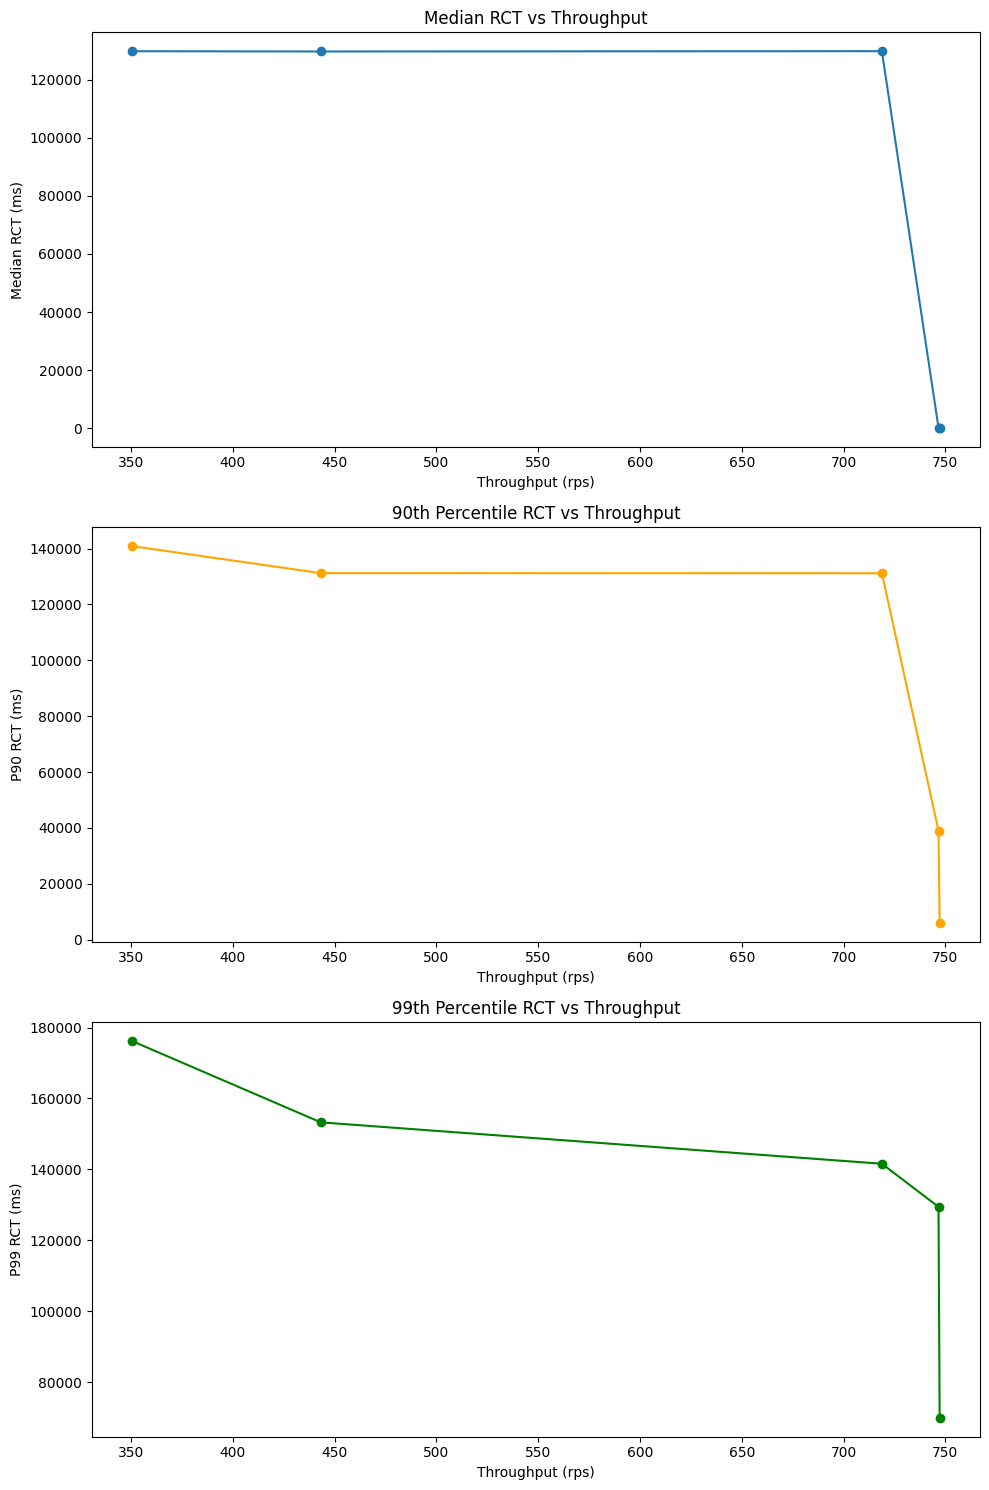

In [5]:
def get_rct_results(rct_chunks_res):
    res = {}  # Key: throughput, value: {'median': ..., 'p90': ..., 'p99': ...}
    for chunk in rct_chunks_res.values():
        print(len(chunk['tids']), chunk['time_elapsed'])
        if chunk['time_elapsed'] > 0:
            chunk_thr = len(chunk['tids']) / chunk['time_elapsed']
        else:
            chunk_thr = 0
        res[chunk_thr] = {
            'median': np.median(chunk['rcts']),
            'p90': np.percentile(chunk['rcts'], 90),
            'p99': np.percentile(chunk['rcts'], 99)
        }
    return res

def plot_rct_results(rct_results):
    """
    Given rct_results as a dictionary mapping throughput -> 
    {'median': ..., 'p90': ..., 'p99': ...}, this function generates three plots:
    one for median, one for p90, and one for p99 RCT values against throughput.
    """
    # Sort the throughput keys for proper ordering in the plot.
    throughput_values = sorted(rct_results.keys())
    print(throughput_values)
    
    # Extract values for each metric.
    median_values = [rct_results[t]['median'] for t in throughput_values]
    p90_values = [rct_results[t]['p90'] for t in throughput_values]
    p99_values = [rct_results[t]['p99'] for t in throughput_values]

    # Create a figure with three subplots (one per metric).
    plt.figure(figsize=(10, 15))

    # Plot median RCT vs Throughput.
    plt.subplot(3, 1, 1)
    plt.plot(throughput_values, median_values, marker='o', linestyle='-')
    plt.title("Median RCT vs Throughput")
    plt.xlabel("Throughput (rps)")
    plt.ylabel("Median RCT (ms)")
    
    # Plot 90th percentile RCT vs Throughput.
    plt.subplot(3, 1, 2)
    plt.plot(throughput_values, p90_values, marker='o', linestyle='-', color='orange')
    plt.title("90th Percentile RCT vs Throughput")
    plt.xlabel("Throughput (rps)")
    plt.ylabel("P90 RCT (ms)")
    
    # Plot 99th percentile RCT vs Throughput.
    plt.subplot(3, 1, 3)
    plt.plot(throughput_values, p99_values, marker='o', linestyle='-', color='green')
    plt.title("99th Percentile RCT vs Throughput")
    plt.xlabel("Throughput (rps)")
    plt.ylabel("P99 RCT (ms)")

    plt.tight_layout()
    plt.show()
    
rct_results = get_rct_results(rct_chunks_res)

plot_rct_results(rct_results)